# 1) Libraries
In this section, we import all the necessary Python libraries for our analysis. These include packages for numerical operations, hierarchical clustering, visualization (including 3D brain plotting), and loading .mat files.

In [ ]:
# General analysis
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

# For loading .mat files
import scipy.io 
import glob

# For hierarchical clustering and distance calculations
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, cut_tree


# For plotting and visualizations
import matplotlib.pyplot as plt

# For saving files and plots
import os

# Suppress warnings to keep the notebook clean
import warnings
warnings.filterwarnings("ignore")

# 2) Class Definitions

## MatrixDiagnostics Class

The MatrixDiagnostics class is designed to perform comprehensive diagnostics on matrices, such as checking for NaN or Inf values, comparing matrices element-wise, analyzing the differences, and identifying the top dissimilar elements. This class can be used to verify the integrity and consistency of matrices, particularly useful when dealing with brain connectivity matrices or other types of numerical data.

### Features:
1) Basic Checks:
* Counts the number of NaN and Inf values in the matrix.
* Checks if the diagonal elements are zero (optional check).

2) Element-wise Similarity:
* Compares the given matrix with a reference matrix (if provided) and computes the percentage of elements that are close to each other within a specified tolerance.

3) Difference Analysis:
* Computes the maximum, mean, and median differences between the matrix and the reference matrix.

4) Top Differences:
* Identifies and displays the top 5 positions with the largest differences between the two matrices.

### Parameters:
* matrix: The matrix to be analyzed.
* reference_matrix: The matrix to compare against (optional).
* name: The name of the matrix for easy identification in the output.
* tolerance: The tolerance used for element-wise comparison (default is 1e-6).

### Usage Example:
matrix_diagnostics = MatrixDiagnostics(matrix, reference_matrix=reference_matrix)
matrix_diagnostics.run_diagnostics()

### Key Methods:
* basic_checks: Perform basic diagnostics such as NaN, Inf, and diagonal checks.
* elementwise_similarity: Compare the matrix to a reference matrix element-wise.
* difference_analysis: Analyze the differences between the matrix and the reference matrix.
* top_differences: Show the top dissimilar elements between the matrix and the reference matrix.

This class is particularly useful for ensuring data integrity when working with large matrices or when comparing matrices obtained from different sources or experiments.

In [23]:
class MatrixDiagnostics:
    
    def __init__(self, matrix, reference_matrix=None, name="matrix", tolerance=1e-6):
        self.matrix = matrix
        self.reference_matrix = reference_matrix
        self.name = name
        self.tolerance = tolerance
    
    def basic_checks(self):
        print(f"\n=== {self.name} Diagnostics ===")
        print("Basic Checks:")
        print(f"NaN count: {np.isnan(self.matrix).sum()}")
        print(f"Inf count: {np.isinf(self.matrix).sum()}")
        print(f"Diagonal zeros: {np.allclose(np.diagonal(self.matrix), 0, atol=1e-6)}")

    def elementwise_similarity(self):
        if self.reference_matrix is not None:
            print("\nMatrix Comparison:")
            close_elements = np.isclose(self.matrix, self.reference_matrix, atol=self.tolerance)
            num_close = np.sum(close_elements)
            total_elements = self.matrix.size
            similarity = num_close / total_elements * 100

            print(f"Elements within ±{self.tolerance}: {num_close}/{total_elements} ({similarity:.2f}%)")
            print(f"Exact matches: {np.sum(self.matrix == self.reference_matrix)}")

    def difference_analysis(self):
        if self.reference_matrix is not None:
            diff = np.abs(self.matrix - self.reference_matrix)
            print("\nDifference Analysis:")
            print(f"Max difference: {np.max(diff):.6f}")
            print(f"Mean difference: {np.mean(diff):.6f}")
            print(f"Median difference: {np.median(diff):.6f}")

    def top_differences(self):
        if self.reference_matrix is not None:
            close_elements = np.isclose(self.matrix, self.reference_matrix, atol=self.tolerance)
            matrix_diff = np.abs(self.matrix - self.reference_matrix)
            
            if np.sum(~close_elements) > 0:
                print("\nDissimilar elements analysis:")
                print(f"Maximum difference in dissimilar elements: {np.max(matrix_diff[~close_elements]):.6f}")
                flat_idx = np.argsort(matrix_diff, axis=None)[-5:]
                row_idx, col_idx = np.unravel_index(flat_idx, self.matrix.shape)
                for i in range(5):
                    r, c = row_idx[-1-i], col_idx[-1-i]
                    print(f"Position ({r}, {c}):")
                    print(f"  matrix: {self.matrix[r,c]:.6f}")
                    print(f"  reference_matrix: {self.reference_matrix[r,c]:.6f}")
                    print(f"  Difference: {matrix_diff[r,c]:.6f}")

    def run_diagnostics(self):
        self.basic_checks()
        if self.reference_matrix is not None:
            self.elementwise_similarity()
            self.difference_analysis()
            self.top_differences()

# 3) Loading Data
Here, we load the preprocessed structural and functional connectivity matrices. These data were obtained from same-subject DTI and rs-fMRI recordings and averaged across 12 healthy subjects. The matrices are stored in a .mat file named average_networks.mat.

In [24]:
# Define path to the .mat file containing averaged connectivity matrices
avgnet_path = r"average_networks.mat"

# Load the .mat file
avgnet_data = scipy.io.loadmat(avgnet_path)

# Print out the keys to see what variables are stored
print("Variables in the .mat file:", avgnet_data.keys())

# Extract the functional connectivity matrix
rsFC_matrix = avgnet_data['func_network']
print("Func Matrix shape:", rsFC_matrix.shape)

# Extract the structural connectivity matrix
SC_matrix = avgnet_data["struct_network"]
print("Struct Matrix shape:", SC_matrix.shape)

Variables in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'func_network', 'struct_network'])
Func Matrix shape: (2514, 2514)
Struct Matrix shape: (2514, 2514)


In [25]:
check_SC = MatrixDiagnostics(SC_matrix, name = "SC_matrix")
check_SC.basic_checks()


=== SC_matrix Diagnostics ===
Basic Checks:
NaN count: 0
Inf count: 0
Diagonal zeros: True


In [26]:
check_rsFC = MatrixDiagnostics(rsFC_matrix, name = "rsFC_matrix")
check_rsFC.basic_checks()


=== rsFC_matrix Diagnostics ===
Basic Checks:
NaN count: 0
Inf count: 0
Diagonal zeros: True


# 3.1) Inspecting a Single Subject's Data
To verify the data structure used for each individual, we load an example subject file (subj00.mat). This file contains both the structural data (fiber_num) and the fMRI time series (time_series) before aggregation into average matrices.

In [27]:
# Load an example subject's data to inspect individual-level structure

path = r"individual_subjects_data\individual_subjects_data\subj00.mat"
pathmath = scipy.io.loadmat(path)

# Print variable names in the file
print(pathmath.keys())

# Inspect the shape of the structural data (fiber numbers)
print("fiber_num shape:", pathmath["fiber_num"].shape)

# Inspect the shape of the fMRI time series data
print("time_series shape:", pathmath["time_series"].shape)

dict_keys(['__header__', '__version__', '__globals__', 'fiber_num', 'time_series'])
fiber_num shape: (2514, 2514)
time_series shape: (190, 2514)


# 4) Load and Average Structural Matrices
In this step, we loop through all individual subject files to extract their structural connectivity (fiber_num) matrices. Then we compute the average structural matrix across all subjects. Finally, we compare this averaged version with the one provided in average_networks.mat to ensure consistency.

In [28]:
# Load all subject files
folder_path = r"individual_subjects_data\individual_subjects_data"
mat_files = sorted(glob.glob(folder_path + r"\subj*.mat"))

# Extract structural matrices and store in a list
sc_matrices = []
for file in mat_files:
    data = scipy.io.loadmat(file)
    sc = data["fiber_num"]
    sc_matrices.append(sc)
    
# Compute average SC matrix across all subjects
avg_SC_matrix = np.mean(sc_matrices, axis=0)

In [29]:
# For SC matrix diagnostics
check_avgSC = MatrixDiagnostics(avg_SC_matrix, reference_matrix = SC_matrix, name= "Avg_SC Matrix")
check_avgSC.run_diagnostics()


=== Avg_SC Matrix Diagnostics ===
Basic Checks:
NaN count: 0
Inf count: 0
Diagonal zeros: True

Matrix Comparison:
Elements within ±1e-06: 6320196/6320196 (100.00%)
Exact matches: 6264300

Difference Analysis:
Max difference: 0.000001
Mean difference: 0.000000
Median difference: 0.000000


# 5) Create and Compare Functional Connectivity (FC) Matrices
This section computes FC matrices from each subject’s fMRI time series using Pearson correlation. These matrices are averaged across subjects. We then compare our computed FC matrices to the one provided in the shared .mat file (rsFC_matrix).

In [30]:
def compute_rsfc_matrix(time_series):
    """Compute Pearson correlation matrix with NaN protection."""
    time_series = np.nan_to_num(time_series)  # Replace NaNs with zeros
    fc_matrix = np.corrcoef(time_series, rowvar=False)
    #np.fill_diagonal(fc_matrix, 1.0)  # Ensure diagonal is exactly 1
    return fc_matrix

# Compute FC matrix for each subject
fc_matrices = []
for file in mat_files:
    data = scipy.io.loadmat(file)
    time_series = data["time_series"]
    fc_matrices.append(compute_rsfc_matrix(time_series))

# Average FC matrix across subjects
avg_rsFC_matrix = np.nanmean(fc_matrices, axis=0)
np.fill_diagonal(avg_rsFC_matrix, 0)  # Optional: enforce diagonal to be 0

In [31]:
check_avg_rsfc = MatrixDiagnostics(avg_rsFC_matrix, reference_matrix= rsFC_matrix, name= "avg_rsfc")
check_avg_rsfc.run_diagnostics()


=== avg_rsfc Diagnostics ===
Basic Checks:
NaN count: 0
Inf count: 0
Diagonal zeros: True

Matrix Comparison:
Elements within ±1e-06: 6037192/6320196 (95.52%)
Exact matches: 2514

Difference Analysis:
Max difference: 0.335402
Mean difference: 0.000413
Median difference: 0.000000

Dissimilar elements analysis:
Maximum difference in dissimilar elements: 0.335402
Position (2332, 1837):
  matrix: 0.560854
  reference_matrix: 0.225452
  Difference: 0.335402
Position (1837, 2332):
  matrix: 0.560854
  reference_matrix: 0.225452
  Difference: 0.335402
Position (2408, 2064):
  matrix: 0.431753
  reference_matrix: 0.765086
  Difference: 0.333333
Position (2064, 2408):
  matrix: 0.431753
  reference_matrix: 0.765086
  Difference: 0.333333
Position (2064, 2332):
  matrix: 0.398457
  reference_matrix: 0.731791
  Difference: 0.333333


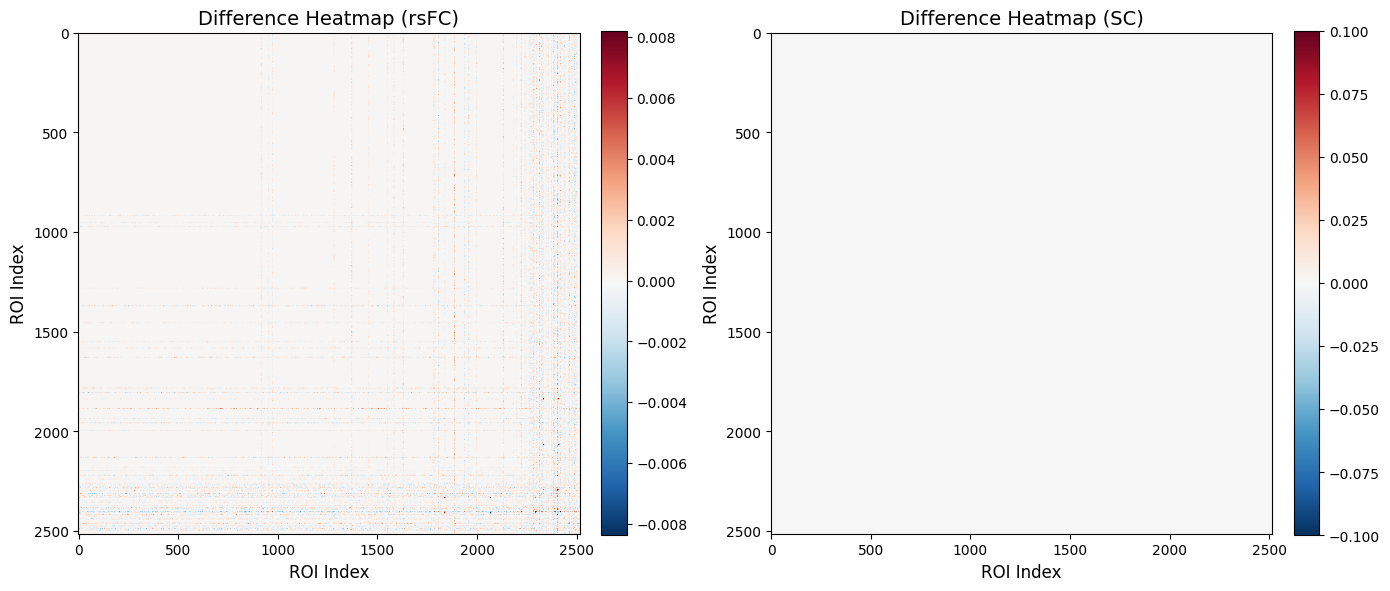

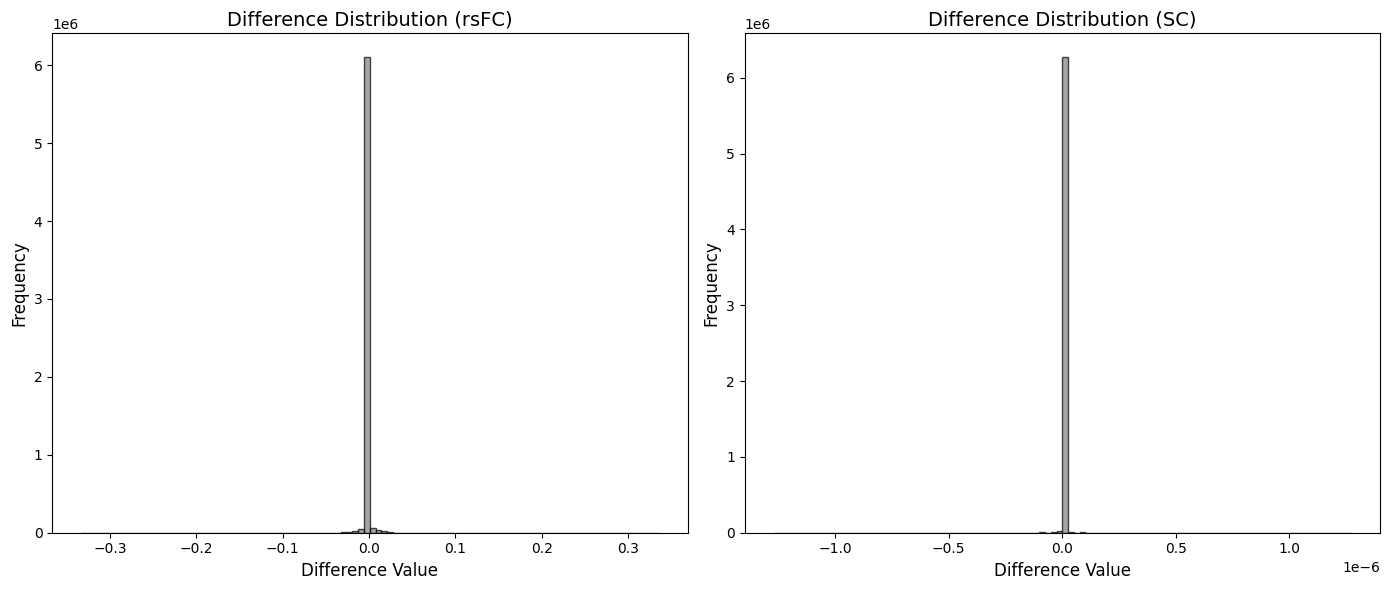

In [ ]:
# Ensure the directory exists
output_dir = 'plot_files'
os.makedirs(output_dir, exist_ok=True)

# Compute the differences
diff = avg_rsFC_matrix - rsFC_matrix
diff_sc = avg_SC_matrix - SC_matrix

# Plotting the difference heatmaps with a more professional look
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# rsFC difference heatmap
im1 = axes[0].imshow(diff, cmap='RdBu_r', vmin=np.percentile(diff, 1), vmax=np.percentile(diff, 99))
axes[0].set_title("Difference Heatmap (rsFC)", fontsize=14)
axes[0].set_xlabel("ROI Index", fontsize=12)
axes[0].set_ylabel("ROI Index", fontsize=12)
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# SC difference heatmap
im2 = axes[1].imshow(diff_sc, cmap='RdBu_r', vmin=np.percentile(diff_sc, 1), vmax=np.percentile(diff_sc, 99))
axes[1].set_title("Difference Heatmap (SC)", fontsize=14)
axes[1].set_xlabel("ROI Index", fontsize=12)
axes[1].set_ylabel("ROI Index", fontsize=12)
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
heatmap_path = os.path.join(output_dir, 'difference_heatmaps.png')
plt.savefig(heatmap_path)
plt.show()
plt.close()

# Plotting the difference distributions with improved presentation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram for rsFC differences
axes[0].hist(diff.flatten(), bins=100, color='gray', edgecolor='black', alpha=0.7)
axes[0].set_title("Difference Distribution (rsFC)", fontsize=14)
axes[0].set_xlabel("Difference Value", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# Histogram for SC differences
axes[1].hist(diff_sc.flatten(), bins=100, color='gray', edgecolor='black', alpha=0.7)
axes[1].set_title("Difference Distribution (SC)", fontsize=14)
axes[1].set_xlabel("Difference Value", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)

plt.tight_layout()
histogram_path = os.path.join(output_dir, 'difference_distributions.png')
plt.savefig(histogram_path)
plt.show()
plt.close()


The recomputed average rsFC matrix closely matches the one provided in the dataset, with over 95% of elements differing by less than ±1e-06. This confirms the reproducibility of the preprocessing pipeline.

Possible Reasons for Differences:
1) Numerical Precision: Floating-point arithmetic can introduce small discrepancies between calculations, especially when comparing large matrices. Even minor differences in rounding or precision settings between software (e.g., Python's NumPy vs. MATLAB) can result in small variations.
2) Order of Operations: The sequence in which mathematical operations are applied (such as averaging, Fisher z-transformation, etc.) might slightly affect the final result. For example, averaging in the z-domain versus the raw correlation space can yield different outcomes.
3) Dataset Preprocessing: The preprocessing steps, such as handling NaNs, outliers, or normalizing the data, may differ slightly between the implementation in the dataset and the custom pipeline used for computation. These small variations could impact the final matrices.
4) Software Differences: MATLAB and Python libraries like NumPy and SciPy may have different algorithms or default settings for functions like np.corrcoef or scipy.io.loadmat. These internal differences might cause slight discrepancies, especially with large datasets.
5) Random Variations: If any of the steps involve random initialization or stochastic methods (e.g., in any iterative algorithms), it could lead to slight differences in the final results.

## 5.1) Matrix Similarity Analysis: Pearson Correlation, MAE, and RMSE

In [32]:
# Use upper triangle indices (excluding diagonal)
triu_indices = np.triu_indices_from(rsFC_matrix, k=1)

# Individual subject matrices
fc_links = rsFC_matrix[triu_indices]
sc_links = SC_matrix[triu_indices]

# Pearson correlation over all connections
r_all, _ = pearsonr(fc_links, sc_links)
print("Pearson r (all connections):", round(r_all, 6))

# Pearson correlation over only physical (nonzero SC) connections
mask = sc_links > 0
r_physical, _ = pearsonr(fc_links[mask], sc_links[mask])
print("Pearson r (SC > 0):", round(r_physical, 6))

# Averaged matrices
fc_links_avg = avg_rsFC_matrix[triu_indices]
sc_links_avg = avg_SC_matrix[triu_indices]

# Pearson correlation over all connections (averaged)
r_all_avg, _ = pearsonr(fc_links_avg, sc_links_avg)
print("Pearson r (all connections, averaged):", round(r_all_avg, 6))

# Pearson correlation over physical connections (averaged)
mask_avg = sc_links_avg > 0
r_physical_avg, _ = pearsonr(fc_links_avg[mask_avg], sc_links_avg[mask_avg])
print("Pearson r (SC > 0, averaged):", round(r_physical_avg, 6))

# Difference between recomputed average rsFC and reference
diff = avg_rsFC_matrix - rsFC_matrix
diff_sc = avg_SC_matrix - SC_matrix
mae = np.mean(np.abs(diff))
rmse = np.sqrt(np.mean(diff**2))
mae_avg = np.mean(np.abs(diff_sc))
rmse_avg = np.sqrt(np.mean(diff_sc**2))

print(f"MAE between recomputed and reference rsFC: {mae:.6f}")
print(f"RMSE between recomputed and reference rsFC: {rmse:.6f}")
print(f"MAE between recomputed and reference SC: {mae_avg:.6f}")
print(f"RMSE between recomputed and reference SC: {rmse_avg:.6f}")


Pearson r (all connections): 0.233276
Pearson r (SC > 0): 0.295396
Pearson r (all connections, averaged): 0.233251
Pearson r (SC > 0, averaged): 0.29477
MAE between recomputed and reference rsFC: 0.000413
RMSE between recomputed and reference rsFC: 0.002611
MAE between recomputed and reference SC: 0.000000
RMSE between recomputed and reference SC: 0.000000


In [34]:
np.savez_compressed(
    'npz_files/matrices.npz',
    rsFC=rsFC_matrix,
    avg_rsFC=avg_rsFC_matrix,
    SC=SC_matrix,
    avg_SC=avg_SC_matrix
)

# 6) Cross-Modularity Index Calculation (Χ)
This section contains Python functions adapted from the [CompNeuroBilbao bha.py GitHub repository](https://github.com/compneurobilbao/bha/blob/master/bha/bha.py), used to compute the cross-modularity index (Χ) between two connectivity matrices (e.g., SC and FC), given a modular partition.

In [20]:
def cross_modularity(A, B, alpha, beta, T):
    """
    Given two input (symmetrical) matrices A and B, this function
    calculates the crossmodularity index X
    
    Parameters
    ----------
    A : array
        squared matrice of N*N (typically connectivity matrices), being N the number of ROIs
    B : array
        squared matrice of N*N (typically connectivity matrices), being N the number of ROIs
    alpha : float
        artibitrary thersholds to binarize the two  matrices (necessary for the similarity calculation)
    beta : float
        artibitrary thersholds to binarize the two  matrices (necessary for the similarity calculation)
    T : array
        label vector: each element vector is defined as an integer corresponding to the module that ROI belongs to
    
    Returns
    -------
    X : float
        crossmodularity
    Qa : array
        modularities of inA associatted to partition T
    Qb : array
        modularities of inB associatted to partition T
    L: float
        similarity between A and B

    """
    # Get the different labels of the modules
    labels = np.unique(T)

    # For each module compute sorensen index
    sorensen = np.zeros(len(labels))
    indx_m = np.empty(0)
    for m in labels:
        # Select the rois of each module and binarizes the resulting matrices using alpha and beta
        indx_m = np.array(np.where(T == labels[m]))
        indx = np.ix_(indx_m[0], indx_m[0])
        bin_A = A[indx] > alpha
        bin_B = B[indx] > beta
        bin_A = bin_A.astype(int)
        bin_B = bin_B.astype(int)
        denom = np.sum(bin_A) + np.sum(bin_B)
        if denom == 0:
            sorensen[m] = 0 
        else:
            sorensen[m] = np.sum(2*(np.multiply(bin_A, bin_B))) / denom

    # The total similarity is the mean similarity of all the modules
    L = np.nanmean(sorensen)

    # Compute the modularity index
    Qa = modularity_index(np.absolute(A), T)
    Qb = modularity_index(np.absolute(B), T)

    # Compute the cross modularity
    X = np.power((np.multiply(np.multiply(Qa, Qb), L)), 1/3)

    return X, Qa, Qb, L


def modularity_index(A, T):
    N = A.shape[0]
    K = np.sum(A, axis=0, keepdims=True)
    m = np.sum(K)
    B = A - (K.T @ K) / m

    s = (T.reshape(-1, 1) == T.reshape(1, -1)).astype(int)

    Q = np.sum(s * B) / m
    return Q

### Notes
* The cross-modularity index (Χ) reflects how well the same modular partition fits both connectivity matrices.
* The Sørensen index is used to quantify the local similarity between binarized matrices within each module.
* This implementation was adapted from the publicly available code by the https://github.com/compneurobilbao/bha

# 7) Cross-Modularity Curve Analysis with Varying Clusters
This section describes the clustering-based analysis of cross-modularity (Χ) between functional and structural brain connectivity matrices. The procedure computes how well structure predicts function and vice versa over a range of cluster numbers using hierarchical clustering and the cross-modularity index.

10) Xsf 0.28410392704565374, Xfs 0.27387568841445675
20) Xsf 0.28924073515960225, Xfs 0.2735071173224537
30) Xsf 0.28506903682684975, Xfs 0.26347681327983863
40) Xsf 0.27975902126286684, Xfs 0.2564821035244937
50) Xsf 0.27509066192068754, Xfs 0.24511576134626678
60) Xsf 0.27344043028003895, Xfs 0.2377063171851645
10) Xsf 0.30016648986924643, Xfs 0.2800789157975748
20) Xsf 0.2970916823674806, Xfs 0.2720942259786658
30) Xsf 0.29651427555879295, Xfs 0.26603462576505843
40) Xsf 0.28032521616985684, Xfs 0.2591859070220003
50) Xsf 0.27832496136118606, Xfs 0.2477754132405983
60) Xsf 0.2710340889114602, Xfs 0.24157990290802372


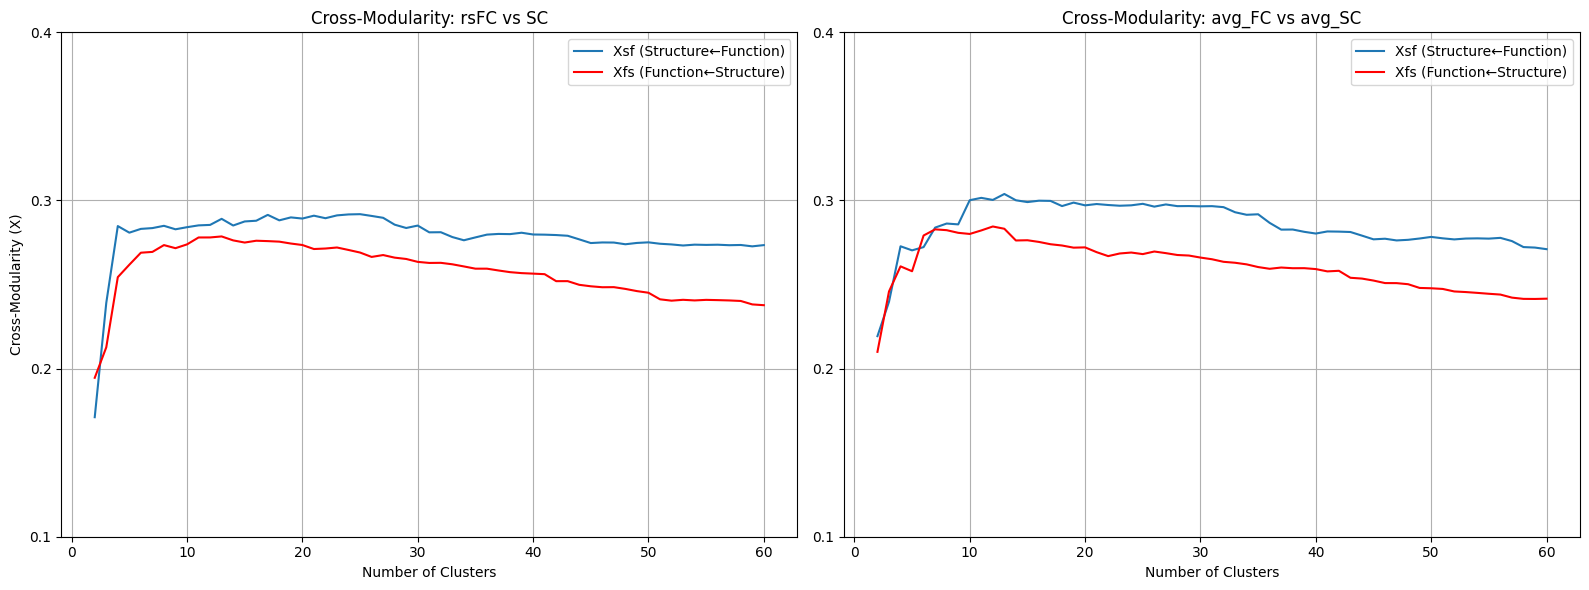

In [21]:
output_dir = 'plot_files'
os.makedirs(output_dir, exist_ok=True)

def cluster_Xsf(network_matrix, number_of_cluster):
    Y = pdist(network_matrix, metric='cosine')
    Z = linkage(Y, method='weighted')
    T = cut_tree(Z, n_clusters=number_of_cluster)[:, 0]
    return T

def cluster_Xfs(network_matrix, number_of_cluster):
    # Ensure values are in [0, 1]
    norm_matrix = np.clip(network_matrix, 0, 1)

    # Convert to distance matrix
    dist_struct = 1 - norm_matrix
    np.fill_diagonal(dist_struct, 0)

    # Convert to condensed format for linkage
    Y_struct = squareform(dist_struct)
    Z_struct = linkage(Y_struct, method='average')

    # Cut the dendrogram into clusters
    T_fs = cut_tree(Z_struct, n_clusters=number_of_cluster)[:, 0]
    return T_fs

def compute_cross_modularity_curve(func_matrix, struct_matrix, alpha, beta, cluster_range):
    Xsf_list = []
    Xfs_list = []
    for k in cluster_range:
        Tsf = cluster_Xsf(func_matrix, k)
        Xsf, *_ = cross_modularity(func_matrix, struct_matrix, alpha, beta, Tsf)
        Xsf_list.append(Xsf)
        
        Tfs = cluster_Xfs(struct_matrix, k)
        Xfs, *_ = cross_modularity(func_matrix, struct_matrix, alpha, beta, Tfs)
        Xfs_list.append(Xfs)
        
        if k%10 == 0:
            
            print(f"{k}) Xsf {Xsf}, Xfs {Xfs}")
            
    return Xsf_list, Xfs_list

# Parameters
cluster_range = range(2, 61)
alpha = 0.45
beta = 0.0

# === First dataset: rsFC_matrix & SC_matrix ===
Xsf_list_1, Xfs_list_1 = compute_cross_modularity_curve(rsFC_matrix, SC_matrix, alpha, beta, cluster_range)

# === Second dataset: avg_rsFC_matrix & avg_SC_matrix ===
Xsf_list_2, Xfs_list_2 = compute_cross_modularity_curve(avg_rsFC_matrix, avg_SC_matrix, alpha, beta, cluster_range)

# === Plotting ===
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: rsFC vs SC
axs[0].plot(cluster_range, Xsf_list_1, label="Xsf (Structure←Function)")
axs[0].plot(cluster_range, Xfs_list_1, label="Xfs (Function←Structure)", color='r')
axs[0].set_title("Cross-Modularity: rsFC vs SC")
axs[0].set_xlabel("Number of Clusters")
axs[0].set_ylabel("Cross-Modularity (X)")
axs[0].set_ylim(0.1, 0.4)
axs[0].set_yticks([0.1, 0.2, 0.3, 0.4])
axs[0].legend()
axs[0].grid(True)

# Subplot 2: avg_rsFC vs avg_SC
axs[1].plot(cluster_range, Xsf_list_2, label="Xsf (Structure←Function)")
axs[1].plot(cluster_range, Xfs_list_2, label="Xfs (Function←Structure)", color='r')
axs[1].set_title("Cross-Modularity: avg_FC vs avg_SC")
axs[1].set_xlabel("Number of Clusters")
axs[1].set_ylim(0.1, 0.4)
axs[1].set_yticks([0.1, 0.2, 0.3, 0.4])
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
crossmod_plot_path = os.path.join(output_dir, 'cross_modularity_curve.png')
plt.savefig(crossmod_plot_path)  # Save BEFORE plt.show()
plt.show()
plt.close()

### Notes
* Xsf assesses how well functionally-derived modules explain structural connectivity.
* Xfs does the opposite: using structure to predict functional organization.
* Plotting these curves helps identify the number of clusters that best align structure and function.